# Reconocimiento de comentarios negativos

En esta libreta vamos a investiar si, utilizando métodos sencillos y 
librerías existentes podemos detectar los comentarios negativos.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Para el tratamiento del lenguaje
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Para el aprendizaje (se agregarán algunas más conforme se necesite)
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.cross_validation import StratifiedKFold
import sklearn.metrics as metricas
from sklearn.learning_curve import learning_curve

plt.rcParams['figure.figsize'] = (30, 20)
plt.style.use('ggplot')
%matplotlib inline



## Paso 1: Recuperar y tratar los datos para usarse

Los datos se encuentran en un directorio privado, los cuales ya se 
encuentran separados de un conjunto de prueba. 

Los datos se encuentran como una tabla tipo csv de la siguiente manera:

Columnas  |    Nombre       |     Descripción
----------|-----------------|----------------------------------------------------------
1         |   id            |    Identificador del mensaje
2         |   create_time   |    Fecha de creación del mensaje
3         |   id_from       |    Identificador del usuario (emisor del mensaje)
4         |   comment       |    El mensaje en si mismo
5         |   like_count    |    Número de likes que recibió el mensaje
6         |   flag          |    Polaridad (0 -> Negativo, 1 -> Positivo, 2 -> Neutro)
7         |   ready         |    Revisado por un operador (1 -> No, 2 -> Si)

Una vez recuperados los datos, se realiza el siguiente pretratamiento:

1. La columna `flag` será el valor de salida y la columna `comment` 
   como variables de entrada, las cuales son string. 
   
2. La columna `comment`la vamos a tratar, ya que cada usuario maneja 
   codificaciones diferentes y los datos están hechos un chile con queso.

3. La columna `flag` se le asigna valor de 0 a los valores 1 y 2 
   (comentarios no negativos) y valor de 1 a los que tienen valor de 0
   (comentarios negativos). Convertimos el problema a un problema de
   clasificación binaria.
   
4. Los datos se separan, 80% para entrenamiento y 20% para validación, 
   procurando que en ambos conjuntos haya la misma proporción de 
   elementos de ambas clases.


In [2]:
# Cargamos los datos
df = pd.read_csv("privado/data_train.csv")

X = df["comment"]
X = X.apply(lambda x: str(x).decode('unicode_escape').encode('utf-8', 'ignore').strip())

y = np.array(df['flag'])

# Problema binario 1 = Comentario negativo
y = np.where(y > 0, 0, 1)

# Separamos 20% para validación
indices = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=0)
for tr_i, va_i in indices:
    X_train, X_valid = X.loc[tr_i], X.loc[va_i]
    y_train, y_valid = y[tr_i], y[va_i]
    break


## Paso 2: Genera la serie de operaciones a realizar.

En esta paso vamos a decidir cuales métodos vamos a utilizar para tratar la información,
y cual método vamos a utilizar para la clasificación. Los métodos que se seleccionen serán
incluídos en un `pipeline` que nos ayuda a serializar las operaciones a realizar.

Entre los métodos de vectorización de la información que podemos utilizar se encuentran:

1. Bolsa de palabras (o bigramas): `CountVectorizer`
2. Tf–idf term weighting: `TfidfVectorizer`

Entre los métodos de reducción de la dimensionalidad se encuentran:

1. Análisis en componentes principales para datos dispersos: `SparsePCA`
2. Latent semantic analysis (LSA): `TruncatedSVD`

Estos pueden ser utilizados en forma combinada. Los métodos de clasificación pueden ser:

1. Máquina de Vectores de Soporte Lineal: `LinearSVC`
2. Máquina de Vectores de Soporte: `SVC`
3. Naive Bayes: `MultinomialNB`
4. Bosques aleatorios: `RandomForestClassifier`
5. AdaBoost: `AdaBoostClassifier`
6. Árbol de desición: `DecisionTreeClassifier`

Por último, es necesario decidir si hay parámetros que pueden ser modificados, y en que términos pueden ser modificados, esto se agrega en el diccionario `parameters`.

In [9]:
espanol_stopwords = stopwords.words('spanish')
vectorizer = TfidfVectorizer(
    analyzer='word',
    lowercase=True,
    ngram_range=(1, 2),
    max_features=40000,
    stop_words=espanol_stopwords)

reductor = TruncatedSVD(n_components=500)

cls = LinearSVC(
    C=1, 
    class_weight={0:0.08, 1:0.9999}, 
    max_iter = 10000)


## Paso 3. Ejecutar el aprendizaje

Hacemos el paso completo, pero vamos a checar todas las combinaciones de parámetros 
para seleccionar la que reduzca un criterio de error. Entre los criterios de error
se encuentran `"recall"` y `"f1"` entre otros.


In [10]:
X_vec = vectorizer.fit_transform(X_train)
X_red = reductor.fit_transform(X_vec)
cls.fit(X_red, y_train)


LinearSVC(C=1, class_weight={0: 0.08, 1: 0.9999}, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=10000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)

## Paso 4: Analisis de los resultados

Por último analizamos que tan bien se desempeña en los datos de validación.


In [11]:
# Muestra los resultados con datos de validacion
X_vec = vectorizer.transform(X_valid)
X_red = reductor.transform(X_vec)
#X_red = X_vec
y_est = cls.predict(X_red)

print metricas.confusion_matrix(y_valid, y_est)


[[9909 3016]
 [ 101 1126]]


In [33]:
def plot_learning_curve(estimator, title, X, y, ylim=None, train_sizes=np.linspace(.5, 1.0, 10)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Ejemplos de entrenamiento")
    plt.ylabel("Errores")
    
    ####################################################################
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, train_sizes=train_sizes)
    ####################################################################
    
    train_scores_mean = np.mean(1 -train_scores, axis=1)
    train_scores_std = np.std(1 - train_scores, axis=1)
    test_scores_mean = np.mean(1 - test_scores, axis=1)
    test_scores_std = np.std(1 - test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label=u"Error de entrenamiento")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label=u"Error de validación")

    plt.legend(loc="best")
    return plt


<module 'matplotlib.pyplot' from '/home/juliowaissman/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

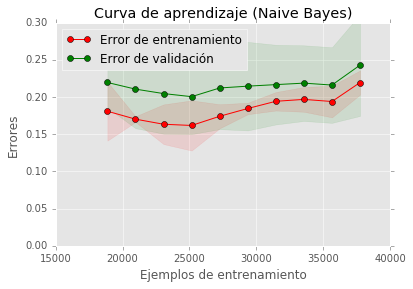

In [34]:
X_vec = vectorizer.fit_transform(X_train)
X_red = reductor.fit_transform(X_vec)

plot_learning_curve(cls, "Curva de aprendizaje (Naive Bayes)", 
                    X_red, y_train, ylim=(0.0, 0.3))
